# Analysis of YouTube Virality with Content Categorization
## Project Phase 2
### IMT 547, Group 4_ Anuj Sinha, Megan Ly, Sungha Kang, Mahir Jain

### Research Questions

* What content does well on YouTube?
* What is the category of content which does well, and are there any noticeable trends in popularity by content category?
* How can we calculate a virality score of each video, through some form of weighted average of already existing metrics (likes, comments, views, etc) to be able to do a easy comparison between the popularity of different videos.

#### Supplemtal Research Questions (if time permits)
* What is the overall sentiment of comments and is there any relation to the category of content being commented on?
* Build some kind of prediction model that is given the transcript and it can predict the virality score, which can be used by creators to update their content to improve virality before posting

### Individual Contributions
1. Research - All
2. Normalization & Virality Score Analysis - Sungha
3. Sentiment Analysis - Megan
4. Overall Documentation - All


In [1]:
# Importing Required Liraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final.csv')
df.drop(columns=['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
df.head()

,channel_name,video_id,video_title,video_description,video_published_at,video_view_count,video_like_count,video_comment_count,transcript,short_transcript,trancript_vader,short_trancript_vader,category,llm_category,filtered_category,filtered_llm_category
0,TwoSetViolin,vcitUfPx8jU,Bradley Cooper didn’t practice 40 hrs 😬,he may be an oscar nominee but can he escape u...,2024-02-16T15:00:58Z,18949,3008,262,hello everyone welcome another episode two set...,hello everyone welcome another episode two set...,0.9997,0.9997,Music,Classical Music,Entertainment,Entertainment
1,TwoSetViolin,sEHQe2TJrxI,wake up babe new viola joke just dropped,Remember to GO PRACTICE. \n___________________...,2024-02-15T13:00:46Z,42901,4008,39,want everyone tell viola joke like well uh say...,want everyone tell viola joke like well uh say...,0.9712,0.9712,Comedy,Comedy,Movies,Entertainment
2,TwoSetViolin,duqlRoxoO-0,When you’re a talented musician but she’s LING...,Remember to GO PRACTICE. \n___________________...,2024-02-14T13:00:27Z,93800,7306,49,music say every orchestra musician literally e...,music say every orchestra musician literally e...,0.9062,0.9062,Music,Entertainment,Entertainment,Entertainment
3,TwoSetViolin,oJG0QUdOiDo,he really considered it... 😛,Remember to GO PRACTICE. \n___________________...,2024-02-13T13:15:06Z,69409,4418,63,honestly everything feels clean clean clean qu...,honestly everything feels clean clean clean qu...,0.7351,0.7351,Politics,Humor,Politics,Emotion
4,TwoSetViolin,OqifbSBS560,He didn’t even care 🥲,NaN,2024-02-11T10:44:54Z,118501,11604,225,oh hey br um going go rehearsal kevin right ok...,oh hey br um going go rehearsal kevin right ok...,0.9637,0.9637,Music,Music,Entertainment,Entertainment


## Data Cleaning

* For the convenience of analysis, a new dataframe was arranged. We found that there was only one category for the 'Vevo' channel, so all rows corresponding to the Vevo channel was deleted.

In [3]:
viral_df = df[['channel_name', 'video_id', 'video_title', 'video_view_count', 'video_like_count', 'video_comment_count', 'filtered_category']]

In [4]:
# Filter the DataFrame for the "Vevo" channel
vevo = viral_df[viral_df['channel_name'] == 'Vevo']['filtered_category'].unique()

# Print the categories
print("Categories of the 'Vevo' channel:")
for category in vevo:
    print(category)

Categories of the 'Vevo' channel:
Entertainment


In [5]:
viral_df = viral_df[viral_df['channel_name'] != 'Vevo']
viral_df.reset_index(drop = True, inplace = True)
viral_df.head()

,channel_name,video_id,video_title,video_view_count,video_like_count,video_comment_count,filtered_category
0,TwoSetViolin,vcitUfPx8jU,Bradley Cooper didn’t practice 40 hrs 😬,18949,3008,262,Entertainment
1,TwoSetViolin,sEHQe2TJrxI,wake up babe new viola joke just dropped,42901,4008,39,Movies
2,TwoSetViolin,duqlRoxoO-0,When you’re a talented musician but she’s LING...,93800,7306,49,Entertainment
3,TwoSetViolin,oJG0QUdOiDo,he really considered it... 😛,69409,4418,63,Politics
4,TwoSetViolin,OqifbSBS560,He didn’t even care 🥲,118501,11604,225,Entertainment


In [6]:
'Vevo' in viral_df['channel_name'].unique()

False

## Normalization for Comparison

#### Normalization of engagement metrics
* **Logarithmic transformation** was applied to take into account the difference in magnitude of each metric (view, like, comment). We attempted to normalize the metrics through logarithmic transformation and reduce the influence of extreme values to lead to a more balanced assessment of virality.
* To consider the size of the channel, each metric was divided by the number of subscribers. This will provide a fair comparison across videos from channels of varying sizes. It allows for the assessment of the relative engagement levels of videos within each channel, considering the size of the channel's subscriber base.

#### Virality Score
* `virality_score` = `normalized_view_count` * `weight_view` + `normalized_like_count` * `weight_like` + `normalized_comment_count` * `weight_comment`
* Previous studies have revealed that each engagement metric contributes to virality differently. In particular, ["Virality over YouTube: an empirical analysis"](https://doi.org/10.1108/IntR-05-2013-0085) found that network dynamics (e.g. in-links and hits counts) and offline social capital (e.g. fan base and fame) play crucial roles in the viral phenomenon, and view count in particular contributes greatly to virality. Therefore, we attempted to accurately reflect the relative importance in driving virality by assigning different levels of importance to each engagement metric.


#### Limitation
* It was challenging to get the number of subscribers at each video publication time, and even if the number of subcribers was retrieved using the API, the number continued to change each time the code was executed. Therefore, at the beginning of the research(Feb 21th, 2024), the subscriber_count was retrieved using ["Real-Time YouTube Live Subscriber Count" website](https://socialcounts.org/youtube-live-subscriber-count), and the virality score was calculated with it.

In [7]:
# Feb 21th, 2024 13:30
# with live sub count

subscriber_counts = {
    'TwoSetViolin': 4306187,
    'Vsauce': 21215333,
    'CNN': 16086878,
    'moneycontrol': 1053358,
    'BBC': 14088705,
    'TBS': 1804228,
    'PewDiePie': 111965109,
    'Smosh': 26613967,
    'WatchMojo.com': 25279777,
    'WIRED': 10986106,
    'BuzzFeedVideo': 19963092,
    'British Vogue': 1539157,
    'Howcast': 9221313,
    'FitnessBlender': 6612932,
    'CinemaSins': 9167082,
    'TheEllenShow': 38100000
}

viral_df['subscriber_count'] = viral_df['channel_name'].map(subscriber_counts)

In [8]:
# Normalize metrics based on subscribers
viral_df['normalized_view_count'] = np.log(viral_df['video_view_count'] + 1) / np.log(viral_df['subscriber_count'] + 1)
viral_df['normalized_like_count'] = np.log(viral_df['video_like_count'] + 1) / np.log(viral_df['subscriber_count'] + 1)
viral_df['normalized_comment_count'] = np.log(viral_df['video_comment_count'] + 1) / np.log(viral_df['subscriber_count'] + 1)

# Define weights for each normalized metric
weight_view = 0.5
weight_like = 0.25
weight_comment = 0.25

# Calculate Weighted Virality Score
viral_df['virality_score'] = (viral_df['normalized_view_count'] * weight_view +
                              viral_df['normalized_like_count'] * weight_like +
                              viral_df['normalized_comment_count'] * weight_comment)

new_order = ['channel_name', 'subscriber_count', 'video_id', 'video_title', 'video_view_count', 'normalized_view_count', 'video_like_count', 'normalized_like_count', 
             'video_comment_count', 'normalized_comment_count', 'virality_score', 'filtered_category']

viral_df = viral_df[new_order]
viral_df.head()


,channel_name,subscriber_count,video_id,video_title,video_view_count,normalized_view_count,video_like_count,normalized_like_count,video_comment_count,normalized_comment_count,virality_score,filtered_category
0,TwoSetViolin,4306187,vcitUfPx8jU,Bradley Cooper didn’t practice 40 hrs 😬,18949,0.644792,3008,0.524325,262,0.364776,0.544671,Entertainment
1,TwoSetViolin,4306187,sEHQe2TJrxI,wake up babe new viola joke just dropped,42901,0.698283,4008,0.543109,39,0.241489,0.545291,Movies
2,TwoSetViolin,4306187,duqlRoxoO-0,When you’re a talented musician but she’s LING...,93800,0.749493,7306,0.582407,49,0.256097,0.584372,Entertainment
3,TwoSetViolin,4306187,oJG0QUdOiDo,he really considered it... 😛,69409,0.729779,4418,0.549483,63,0.272257,0.570325,Politics
4,TwoSetViolin,4306187,OqifbSBS560,He didn’t even care 🥲,118501,0.764796,11604,0.612690,225,0.354850,0.624283,Entertainment


## Data Visualization & Analysis

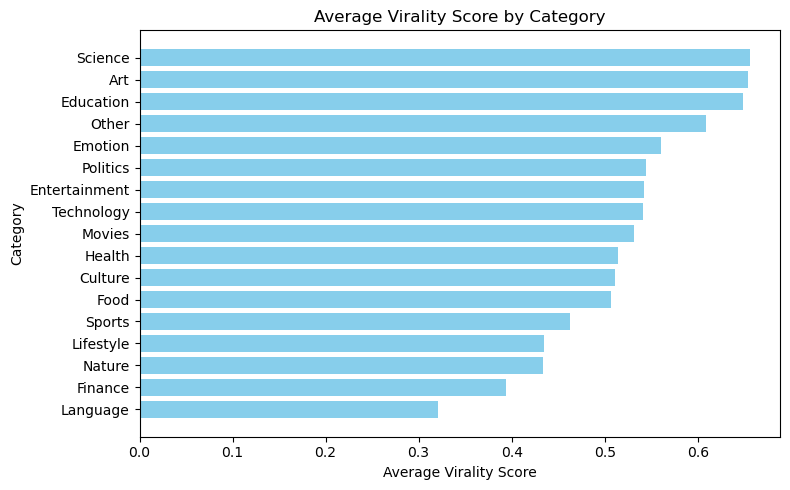

In [9]:
## Average Virality Score by Category

# Group by Category and calculate average virality score
avg_virality = viral_df.groupby('filtered_category')['virality_score'].mean().reset_index()

# Sort categories by virality score
avg_virality_sorted = avg_virality.sort_values(by='virality_score')

# Create the plot
plt.figure(figsize=(8, 5))
plt.barh(avg_virality_sorted['filtered_category'], avg_virality_sorted['virality_score'], color='skyblue')

plt.xlabel('Average Virality Score')
plt.ylabel('Category')
plt.title('Average Virality Score by Category')
plt.tight_layout()
plt.show()
